<a href="https://colab.research.google.com/github/umji4500/Master-Thesis/blob/main/Ground_Track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File: sso_pass_solver.py

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, time, timezone
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time # For timing

# Constants
MU = 3.986004418e14       # Earth's gravitational parameter, m^3/s^2
R_EARTH = 6371e3          # Earth radius, m
J2 = 1.08263e-3           # Earth’s J2 perturbation coefficient
OMEGA_DOT_SUN = 1.99106e-7 # Desired RAAN drift for SSO, rad/s
OMEGA_EARTH = 7.2921159e-5  # Earth rotation rate, rad/s

# Epoch and simulation time
EPOCH = datetime(2025, 3, 20, 0, 0, 0)
TIME_STEP = 1
SIM_DURATION = 24 * 3600
# Ground target (Incheon Airport)
TARGET_LAT = np.radians(37.4602)
TARGET_LON = np.radians(126.4407)

# Minimum elevation for visibility check (radians)
MIN_ELEVATION = np.radians(20)

def compute_elevation(lat_sat, lon_sat, lat_target, lon_target, sat_alt):
    x_sat = (R_EARTH + sat_alt) * np.cos(lat_sat) * np.cos(lon_sat)
    y_sat = (R_EARTH + sat_alt) * np.cos(lat_sat) * np.sin(lon_sat)
    z_sat = (R_EARTH + sat_alt) * np.sin(lat_sat)

    x_tgt = R_EARTH * np.cos(lat_target) * np.cos(lon_target)
    y_tgt = R_EARTH * np.cos(lat_target) * np.sin(lon_target)
    z_tgt = R_EARTH * np.sin(lat_target)

    dx = x_sat - x_tgt
    dy = y_sat - y_tgt
    dz = z_sat - z_tgt
    r_vec = np.array([dx, dy, dz])
    r_mag = np.linalg.norm(r_vec)

    tgt_vec = np.array([x_tgt, y_tgt, z_tgt])
    tgt_unit = tgt_vec / np.linalg.norm(tgt_vec)
    cos_theta = np.dot(r_vec, tgt_unit) / r_mag
    return np.arcsin(cos_theta)  # returns radians


def orbital_period(a):
    return 2 * np.pi * np.sqrt(a**3 / MU)

def inclination_for_sso(a):
    e = 0
    n = np.sqrt(MU / a**3)
    term = (-2 * OMEGA_DOT_SUN * a**2) / (3 * J2 * R_EARTH**2 * n)
    term = np.clip(term, -1.0, 1.0)
    return np.arccos(term)

def solve_kepler(M, e, tol=1e-8):
    E = M if e < 0.8 else np.pi
    for _ in range(100):
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        E -= f / f_prime
        if abs(f) < tol:
            break
    return E


# --- Propagate_orbit Definition ---
def propagate_orbit(a, e, inc, RAAN, AOP, M0, duration_sec=SIM_DURATION, dt_sec=TIME_STEP):
    """Propagates orbit considering J2 perturbations for a given duration and time step."""
    n = np.sqrt(MU / a**3)
    if dt_sec <= 0:
        print("   ❌ Error: dt_sec must be positive.")
        return None, None
    try:
        steps = int(duration_sec / dt_sec)
    except ZeroDivisionError:
         print("   ❌ Error: Division by zero. dt_sec cannot be zero.")
         return None, None

    if steps <= 0:
        print(f"   ⚠️ Warning: Calculated steps ({steps}) is not positive. Check duration_sec and dt_sec.")

    positions = []
    times = []

    # Precession rates
    p = a * (1 - e**2)
    Omega_dot = -1.5 * J2 * (R_EARTH**2) * n * np.cos(inc) / (p**2)
    omega_dot = 0.75 * J2 * (R_EARTH**2) * n * (5 * np.cos(inc)**2 - 1) / (p**2)
    M_dot = n + 0.75 * J2 * (R_EARTH**2) * n * (3 * np.cos(inc)**2 - 1) / (p**2)

    for step in range(steps):
        t = step * dt_sec
        RAAN_t = RAAN + Omega_dot * t
        AOP_t = AOP + omega_dot * t
        M_t = M0 + M_dot * t
        E = solve_kepler(M_t % (2 * np.pi), e)
        TA = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E / 2),
                           np.sqrt(1 - e) * np.cos(E / 2))

        r_mag = a * (1 - e * np.cos(E))
        r_pf = np.array([r_mag * np.cos(TA), r_mag * np.sin(TA), 0])

        cos_RAAN, sin_RAAN = np.cos(RAAN_t), np.sin(RAAN_t)
        cos_inc, sin_inc = np.cos(inc), np.sin(inc)
        cos_AOP, sin_AOP = np.cos(AOP_t), np.sin(AOP_t)

        R1 = np.array([[cos_RAAN, -sin_RAAN, 0], [sin_RAAN, cos_RAAN, 0], [0, 0, 1]])
        R2 = np.array([[1, 0, 0], [0, cos_inc, -sin_inc], [0, sin_inc, cos_inc]])
        R3 = np.array([[cos_AOP, -sin_AOP, 0], [sin_AOP, cos_AOP, 0], [0, 0, 1]])
        r_eci = R1 @ R2 @ R3 @ r_pf

        gst = OMEGA_EARTH * t
        cos_gst, sin_gst = np.cos(gst), np.sin(gst)
        x = r_eci[0] * cos_gst + r_eci[1] * sin_gst
        y = -r_eci[0] * sin_gst + r_eci[1] * cos_gst
        z = r_eci[2]
        positions.append((x, y, z))
        times.append(EPOCH + timedelta(seconds=int(t)))

    return np.array(positions), np.array(times)

def eci_to_latlon(r_vec):
    x, y, z = r_vec
    r = np.linalg.norm(r_vec)
    lat = np.arcsin(z / r)
    lon = np.arctan2(y, x)
    return lat, lon

def is_visible(lat_sat, lon_sat, lat_target, lon_target, sat_alt):
    return compute_elevation(lat_sat, lon_sat, lat_target, lon_target, sat_alt) >= MIN_ELEVATION


# --- find_passes Definition (Returning Pass Times & Keeping Plot) ---
def find_passes(a, e, inc, RAAN, AOP, M0, plot=False, duration_sec=SIM_DURATION, dt_sec=TIME_STEP):

    # Initialize lists
    pass_durations = []
    current_pass = []
    all_pass_times = []
    latitudes = []
    longitudes = []

    pos, times = None, None
    try:
        # Ensure propagate_orbit is modified to accept duration_sec/dt_sec
        pos, times = propagate_orbit(a, e, inc, RAAN, AOP, M0, duration_sec=duration_sec, dt_sec=dt_sec)
        if pos is None or times is None or not isinstance(pos, np.ndarray) or not isinstance(times, np.ndarray) or len(pos) == 0 or len(times) == 0 or len(pos) != len(times):
             print(f"   ❌ Error: propagate_orbit did not return valid data for M0={np.degrees(M0):.1f}.")
             return 0, 0, 0, []
    except Exception as prop_e:
        print(f"   ❌ Error in propagate_orbit call for M0={np.degrees(M0):.1f}: {prop_e}")
        return 0, 0, 0, []
    try:
        # Calculate visibility and collect pass data
        for r_vec, t in zip(pos, times):
            lat, lon = eci_to_latlon(r_vec)
            latitudes.append(np.degrees(lat))
            longitudes.append(np.degrees(lon))
            if is_visible(lat, lon, TARGET_LAT, TARGET_LON, np.linalg.norm(r_vec) - R_EARTH):
                current_pass.append(t)
            else:
                if current_pass:
                    duration = (current_pass[-1] - current_pass[0]).total_seconds() + dt_sec
                    pass_durations.append(duration)
                    all_pass_times.append((current_pass[0], current_pass[-1]))
                    current_pass = []

        # Handle pass ending exactly at simulation end
        if current_pass:
             duration = (current_pass[-1] - current_pass[0]).total_seconds() + dt_sec
             pass_durations.append(duration)
             all_pass_times.append((current_pass[0], current_pass[-1]))

    except Exception as vis_e:
         print(f"   ❌ Error during visibility calculation for M0={np.degrees(M0):.1f}: {vis_e}")
         return 0, 0, 0, []

    # --- Calculate Summary Metrics ---
    max_pass = max(pass_durations, default=0)
    total_visible = sum(pass_durations)
    num_passes = len(all_pass_times) # Count based on the list of tuples

    # --- MODIFIED RETURN STATEMENT ---
    return max_pass, total_visible, num_passes, all_pass_times

# --- Define KST Offset --- ##
kst_offset = timedelta(hours=9) # KST = UTC+9

# --- Function to Identify Daytime Passes (Daily KST Times & Overlap) --- ##
def get_daytime_passes_detailed(pass_start_times_utc, pass_end_times_utc, daily_sun_times_kst):
    """
    Filters passes based on daily KST sunrise/sunset times using overlap logic.
    Args:
        pass_start_times_utc (list): List of pass start datetimes (naive but represent UTC).
        pass_end_times_utc (list): List of pass end datetimes (naive but represent UTC).
        daily_sun_times_kst (dict): Dictionary mapping 'YYYY-MM-DD' string to
                                    (sunrise_time, sunset_time) tuple (datetime.time objects in KST).
    Returns:
        tuple: (daytime_pass_indices, num_daytime_passes)
    """
    num_daytime_passes = 0
    daytime_indices = []

    if pass_start_times_utc is None or pass_end_times_utc is None or len(pass_start_times_utc) == 0:
        return [], 0

    for index, (start_utc_naive, end_utc_naive) in enumerate(zip(pass_start_times_utc, pass_end_times_utc)):
        try:
            # --- Make naive datetimes UTC-aware ---
            if not isinstance(start_utc_naive, datetime) or not isinstance(end_utc_naive, datetime):
                 print(f"      ⚠️ Warning: Invalid datetime object type at index {index}. Skipping pass.")
                 continue

            start_utc = start_utc_naive.replace(tzinfo=timezone.utc)
            end_utc = end_utc_naive.replace(tzinfo=timezone.utc)


            start_kst = start_utc + kst_offset
            end_kst = end_utc + kst_offset
            pass_date_str = start_kst.strftime('%Y-%m-%d')

            if pass_date_str not in daily_sun_times_kst:
                prev_day_dt = start_kst - timedelta(days=1)
                prev_pass_date_str = prev_day_dt.strftime('%Y-%m-%d')
                if prev_pass_date_str in daily_sun_times_kst:
                     pass_date_str = prev_pass_date_str
                else:
                     continue

            sunrise_kst_time, sunset_kst_time = daily_sun_times_kst[pass_date_str]
            kst_tz = timezone(kst_offset)
            sunrise_dt_kst = datetime.combine(start_kst.date(), sunrise_kst_time, tzinfo=kst_tz)
            sunset_dt_kst = datetime.combine(start_kst.date(), sunset_kst_time, tzinfo=kst_tz)

            # --- Check for Overlap ---
            has_overlap = (start_kst < sunset_dt_kst) and (end_kst > sunrise_dt_kst)

            if has_overlap:
                num_daytime_passes += 1
                daytime_indices.append(index)

        except Exception as e:
            print(f"      ⚠️ Warning: Could not process pass index {index} (Start UTC: {start_utc_naive}, End UTC: {end_utc_naive}): {e}")

    return daytime_indices, num_daytime_passes





In [ ]:
orbit_configs = [
    {"label": "SSO-1d",        "alt_km": 685, "inc": 98.12,  "RAAN": 300, "AOP": 0,   "M0": 0,   "e": 0.0001},
    {"label": "NSSO-1d-45",    "alt_km": 685, "inc": 45.00,  "RAAN": 60,  "AOP": 0,   "M0": 300, "e": 0.001},
    {"label": "NSSO-1d-50",    "alt_km": 685, "inc": 50.00,  "RAAN": 60,  "AOP": 0,   "M0": 300, "e": 0.001},
    {"label": "NSSO-1d-60",    "alt_km": 685, "inc": 60.00,  "RAAN": 120, "AOP": 0,   "M0": 180, "e": 0.001},
    {"label": "NSSO-1d-70",    "alt_km": 685, "inc": 70.00,  "RAAN": 120, "AOP": 0,   "M0": 180, "e": 0.001},
    {"label": "NSSO-1d-110",   "alt_km": 685, "inc": 110.00, "RAAN": 240, "AOP": 0,   "M0": 60,  "e": 0.001},
    {"label": "NSSO-1d-30",   "alt_km": 685, "inc": 30.00, "RAAN": 0, "AOP": 0,   "M0": 0,  "e": 0.001},
    {"label": "NSSO-1d-20",   "alt_km": 685, "inc": 20.00, "RAAN": 0, "AOP": 0,   "M0": 0,  "e": 0.001},
    {"label": "NSSO-1d-150",   "alt_km": 685, "inc": 150.00, "RAAN": 0, "AOP": 0,   "M0": 0,  "e": 0.001},

]



--- Plotting SSO-1d ---


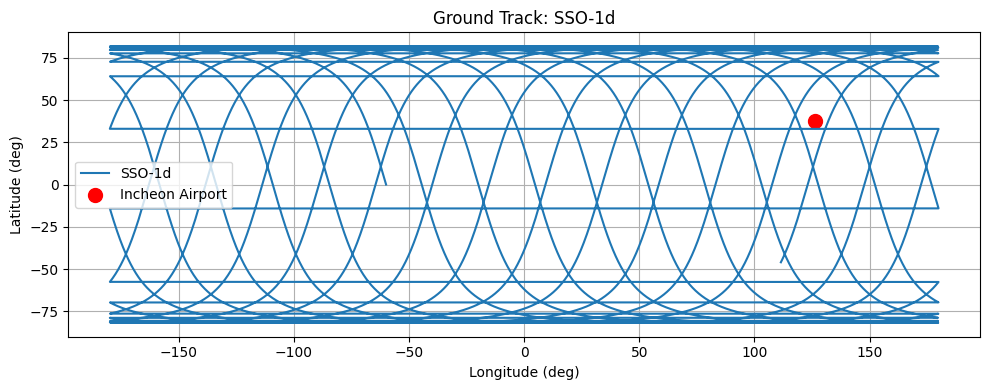

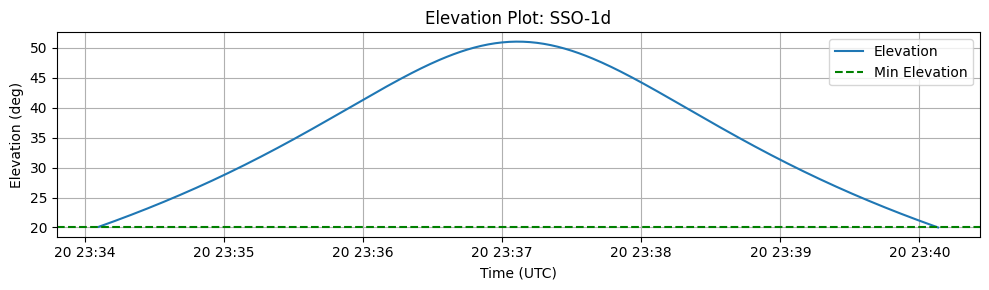


--- Plotting NSSO-1d-45 ---


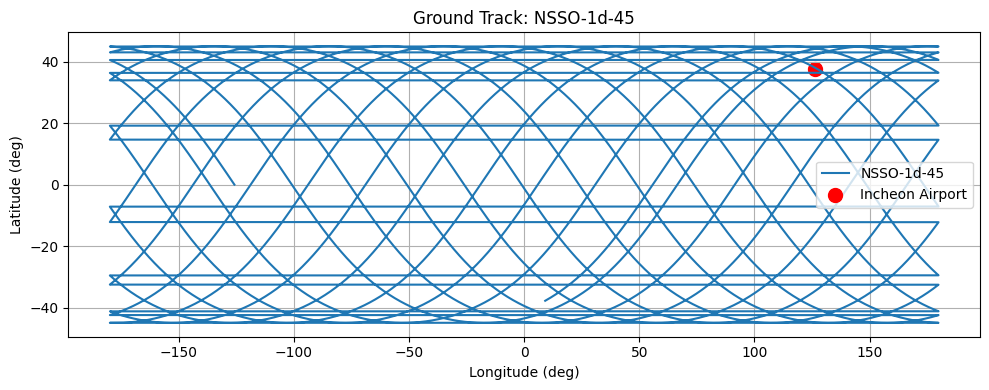

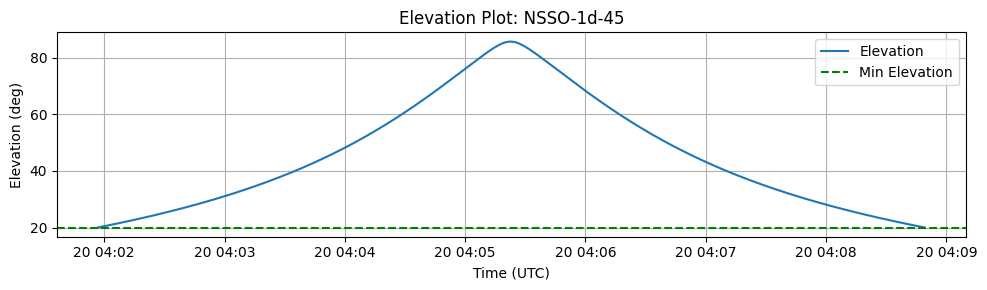


--- Plotting NSSO-1d-50 ---


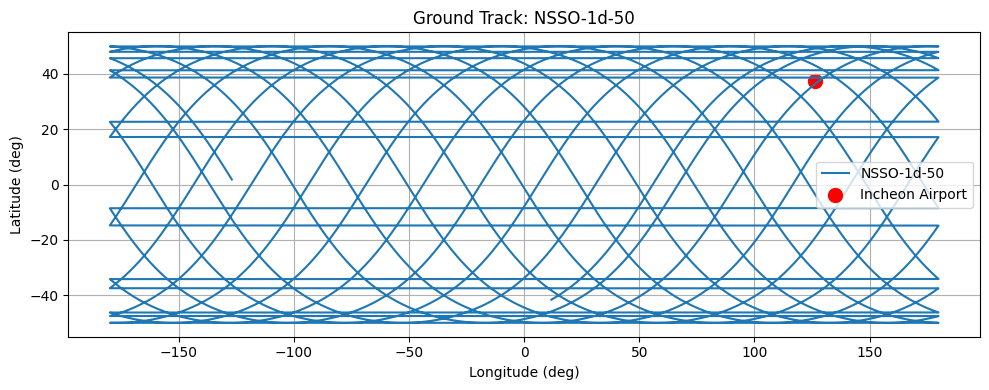

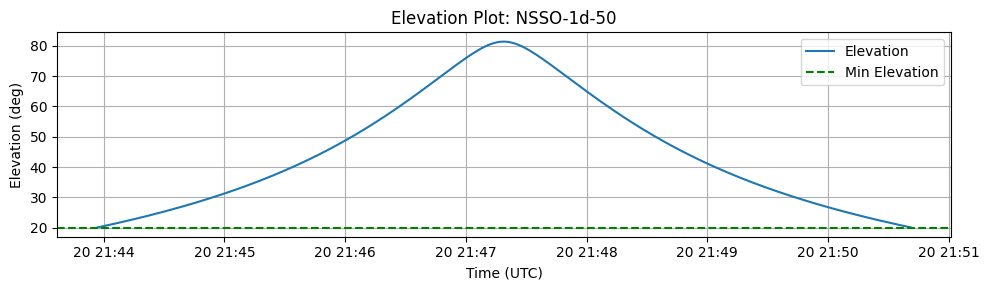


--- Plotting NSSO-1d-60 ---


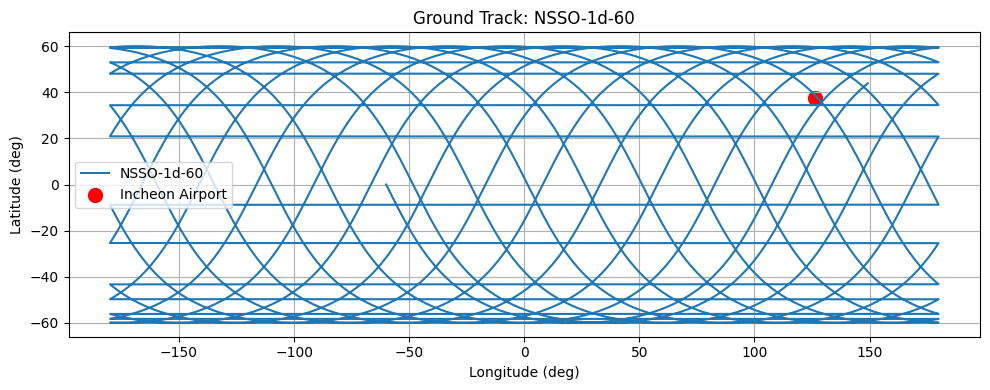

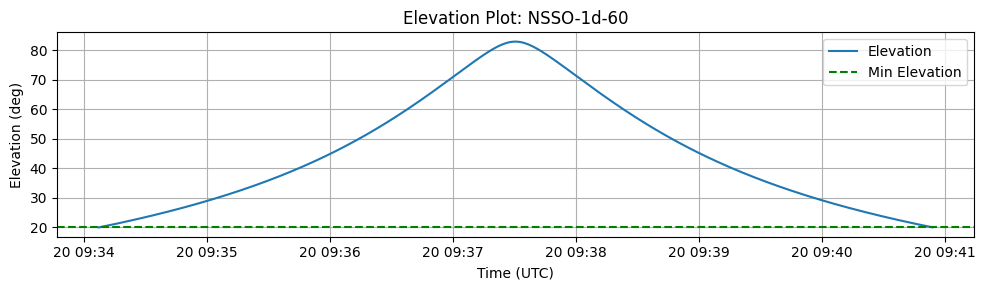


--- Plotting NSSO-1d-70 ---


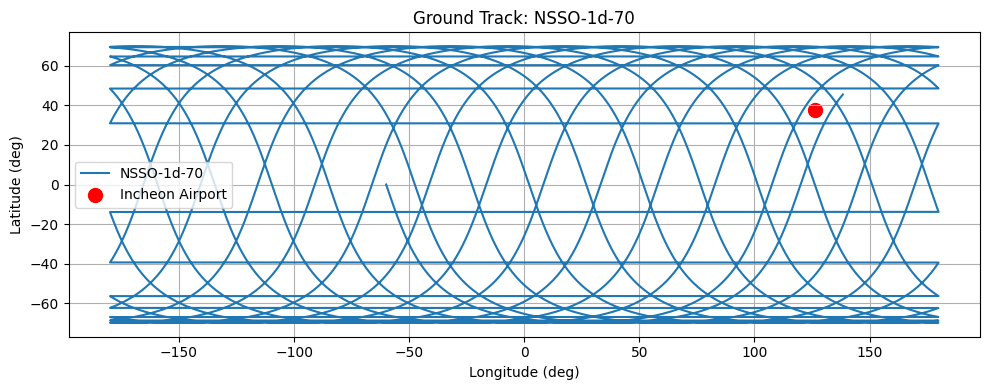

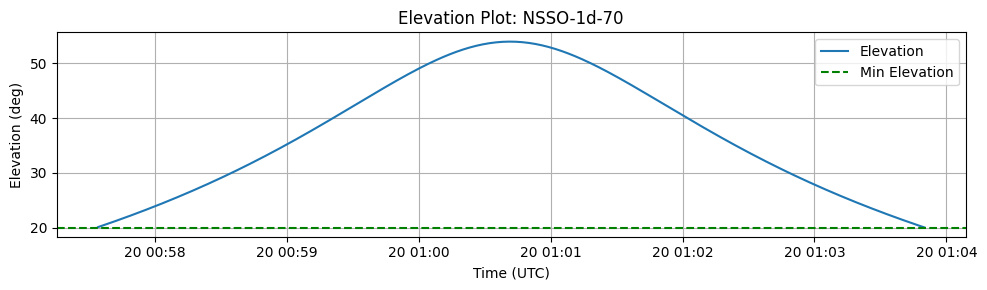


--- Plotting NSSO-1d-110 ---


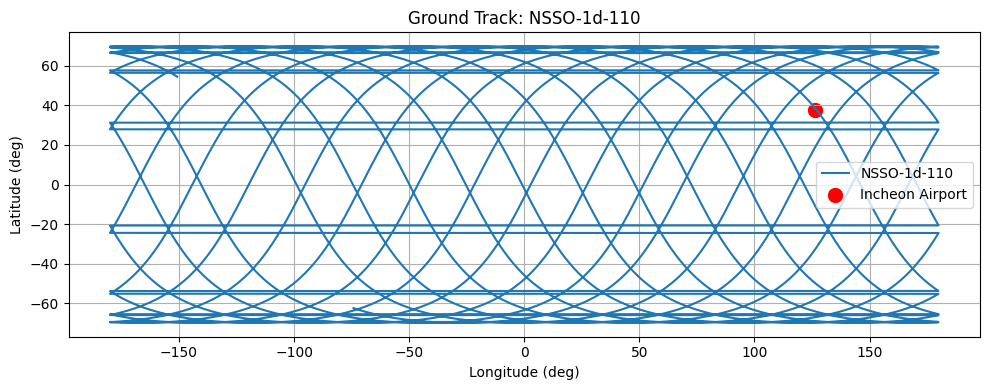

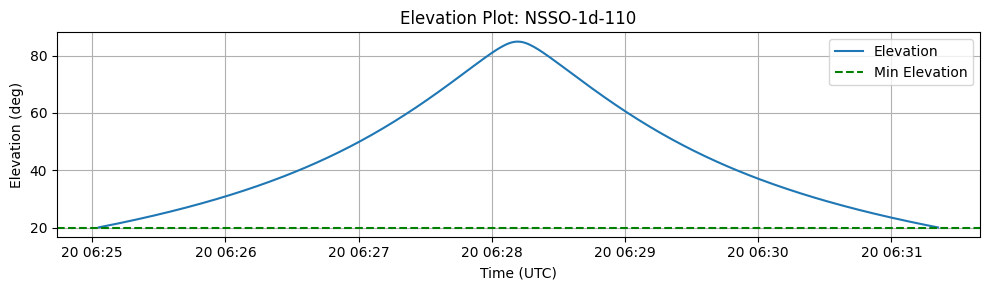


--- Plotting NSSO-1d-30 ---


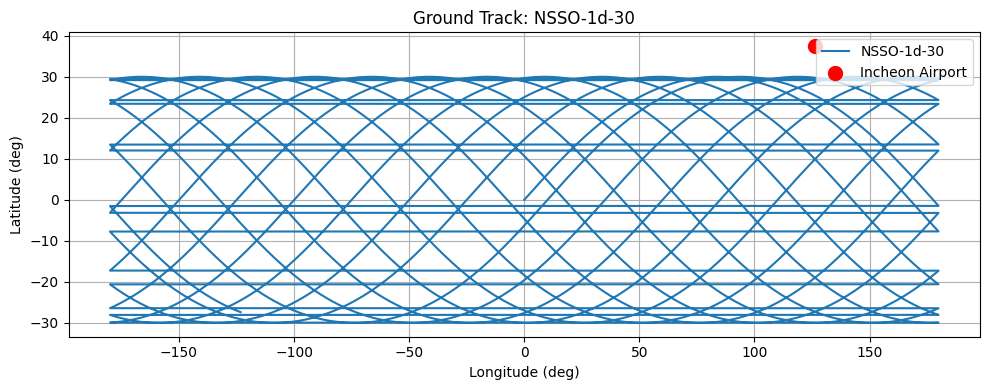

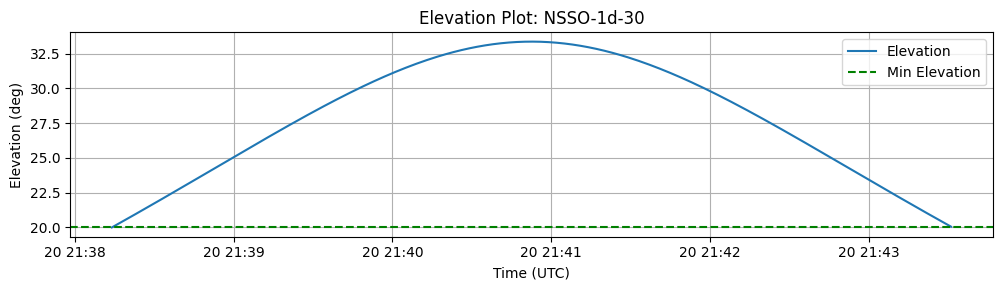


--- Plotting NSSO-1d-20 ---
⚠️ No valid pass found for NSSO-1d-20

--- Plotting NSSO-1d-150 ---


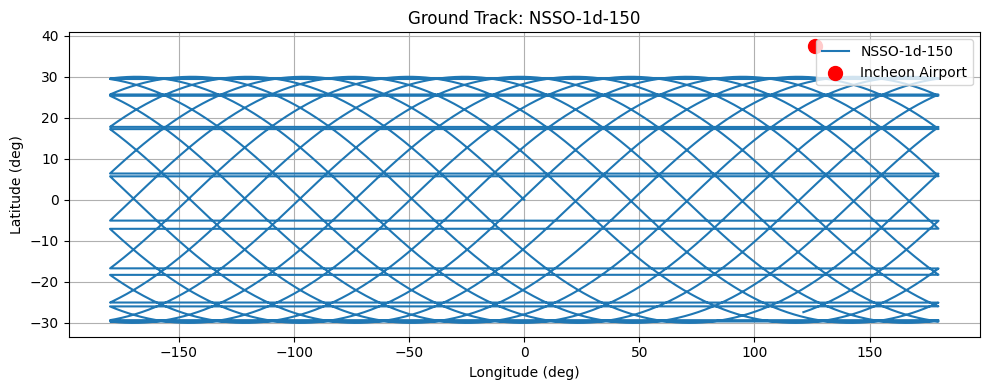

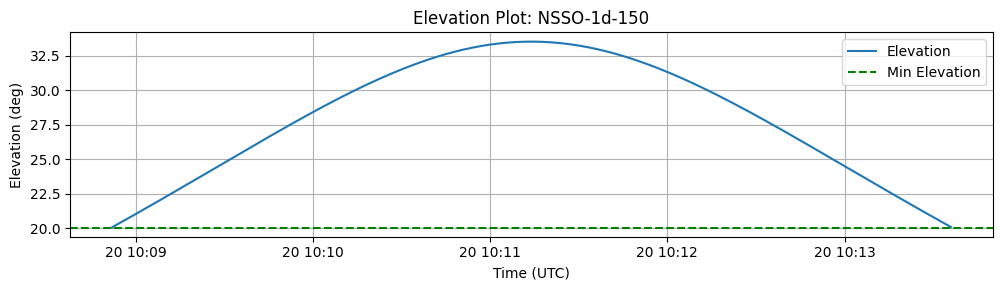

In [ ]:
for config in orbit_configs:
    print(f"\n--- Plotting {config['label']} ---")

    # Orbit Parameter
    a = R_EARTH + config["alt_km"] * 1e3
    e = config["e"]
    inc = np.radians(config["inc"])
    RAAN = np.radians(config["RAAN"])
    AOP = np.radians(config["AOP"])
    M0 = np.radians(config["M0"])

    # Pass
    max_pass, total_vis, num_passes, pass_times = find_passes(a, e, inc, RAAN, AOP, M0, plot=False)
    positions, times = propagate_orbit(a, e, inc, RAAN, AOP, M0)

    if not pass_times or positions is None:
        print(f"⚠️ No valid pass found for {config['label']}")
        continue

    best_idx = np.argmax([(end - start).total_seconds() for start, end in pass_times])
    best_start, best_end = pass_times[best_idx]

    # === Ground Track ===
    latitudes = []
    longitudes = []

    for r_vec in positions:
        lat, lon = eci_to_latlon(r_vec)
        latitudes.append(np.degrees(lat))
        longitudes.append(np.degrees(lon))

    plt.figure(figsize=(10, 4))
    plt.plot(longitudes, latitudes, label=config['label'])
    plt.scatter(np.degrees(TARGET_LON), np.degrees(TARGET_LAT), color='red', s=100, label='Incheon Airport')
    plt.title(f"Ground Track: {config['label']}")
    plt.xlabel("Longitude (deg)")
    plt.ylabel("Latitude (deg)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Elevation Plot ===
    elev_times, elev_angles = [], []
    for r_vec, t in zip(positions, times):
        if best_start <= t <= best_end:
            lat, lon = eci_to_latlon(r_vec)
            alt = np.linalg.norm(r_vec) - R_EARTH
            elev = compute_elevation(lat, lon, TARGET_LAT, TARGET_LON, alt)
            if elev >= MIN_ELEVATION:
                elev_times.append(t)
                elev_angles.append(np.degrees(elev))

    if elev_angles:
        plt.figure(figsize=(10, 3))
        plt.plot(elev_times, elev_angles, label='Elevation')
        plt.axhline(np.degrees(MIN_ELEVATION), linestyle='--', color='green', label='Min Elevation')
        plt.title(f"Elevation Plot: {config['label']}")
        plt.xlabel("Time (UTC)")
        plt.ylabel("Elevation (deg)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ No elevation above threshold in longest pass for {config['label']}")
